# Importing Modules

In [1]:
import os
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.utils.vis_utils import plot_model

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Preparing Dataset

In [2]:
import random

# Path to the data directory
data_dir = Path("/kaggle/input/captcha-dataset")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images))
print("Random image: ", random.choice(images))
print("Number of labels found: ", len(labels))
print("Random label: ", random.choice(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Desired image dimensions
img_width = 150
img_height = 40

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])

Number of images found:  113062
Random image:  /kaggle/input/captcha-dataset/qtZM5.jpg
Number of labels found:  113062
Random label:  h7smM
Number of unique characters:  60
Characters present:  ['1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [3]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.8, val_size=0.1, test_size=0.1, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images)
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    val_samples = int(size * (train_size + val_size))
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:val_samples]], labels[indices[train_samples:val_samples]]
    x_test, y_test = images[indices[val_samples:]], labels[indices[val_samples:]]
    return x_train, x_valid, x_test, y_train, y_valid, y_test

# Splitting data into training and validation sets
_, _, x_test, _, _, y_test = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_jpeg(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}

# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [4]:
test_dataset_batch1 = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset_batch1 = (
    test_dataset_batch1.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(1)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_dataset_batch16 = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset_batch16 = (
    test_dataset_batch16.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(16)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

# Setting up file paths for model testing

In [5]:
#Path to pretrained model
from tensorflow.keras.models import load_model
path = '/kaggle/input/captcha-final-model/final_model/latest_model'

model = load_model(path)

In [6]:
model.summary()

Model: "captcha_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 150, 40, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 150, 40, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 75, 20, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 75, 20, 64)   18496       ['pool1[0][0]']      

In [7]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)

# **Test the Model**

1/1 [==============================] - 6s 6s/step


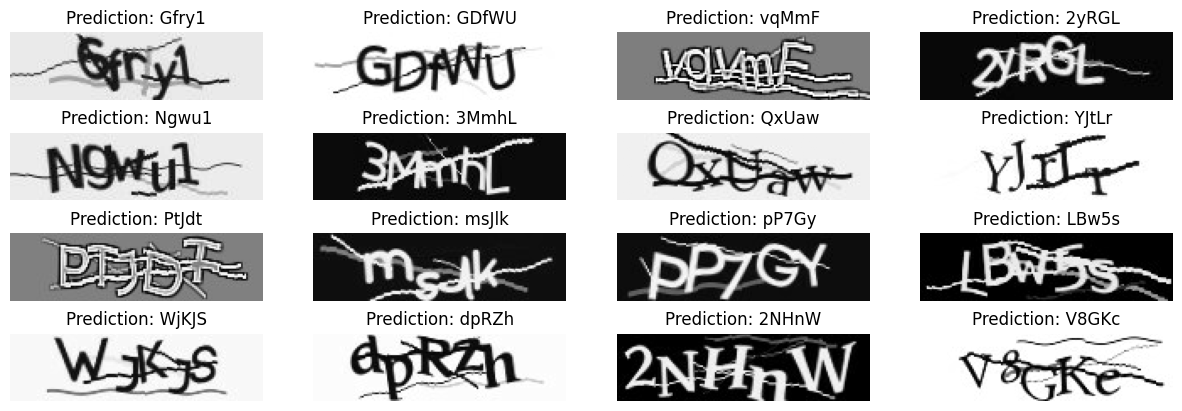

In [8]:
import random

test_dataset_batch16 = test_dataset_batch16.shuffle(707, reshuffle_each_iteration=True)

for batch in test_dataset_batch16.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")    
        
    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()

1/1 [==============================] - 0s 42ms/step


(-0.5, 149.5, 39.5, -0.5)

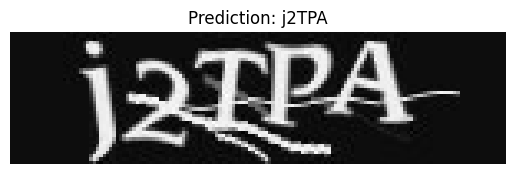

In [9]:
test_dataset_batch1 = test_dataset_batch1.shuffle(707, reshuffle_each_iteration=True)

for batch in test_dataset_batch1.take(1):
  batch_images = batch["image"]
  batch_labels = batch["label"]

  preds = prediction_model.predict(batch_images)
  pred_texts = decode_batch_predictions(preds)

img = (batch_images[0, :, :, 0] * 255).numpy().astype(np.uint8)
img = img.T    

title = f"Prediction: {pred_texts[0]}"
plt.title(title)
plt.imshow(img, cmap="gray")
plt.axis("off")

# The Model's prediction of the following Text Captcha Images